# LSTM & Word Embeddings for Sentiment Classification

## Imports & Settings

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import minmax_scale
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.datasets import imdb
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Input, concatenate, Embedding, Reshape
from keras.preprocessing.sequence import pad_sequences
import keras
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
sns.set_style('whitegrid')
np.random.seed(42)
K.clear_session()

## Load Reviews

To keep the data manageable, we will illustrate this use case with the IMDB reviews dataset, which contains 50,000 positive and negative movie reviews evenly split into a train and a test set, and with balanced labels in each dataset. The vocabulary consists of 88,586 tokens.

The dataset is bundled into Keras and can be loaded so that each review is represented as an integer-encoded sequence. We can limit the vocabulary to num_words while filtering out frequent and likely less informative words using skip_top, as well as sentences longer than maxlen. We can also choose oov_char, which represents tokens we chose to exclude from the vocabulary on frequency grounds, as follows:

In [3]:
vocab_size = 20000

In [4]:
json_df=pd.read_csv('json_df_cleaned_train_val_1.csv')

In [5]:
reviews = np.array(json_df['Tidy_Tweet'])
sentiments = np.array(json_df['Sentiment_score'])

In [4]:
# (X_train, y_train), (X_test, y_test) = imdb.load_data(seed=42, 
#                                                       skip_top=0,
#                                                      maxlen=None, 
#                                                       oov_char=2, 
#                                                       index_from=3
#                                                       num_words=vocab_size)

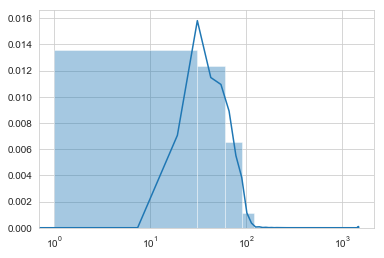

In [6]:
ax = sns.distplot([len(review) for review in reviews])
ax.set(xscale='log');

## Prepare Data

In [10]:
sentiment_ohe = pd.get_dummies(sentiments)
sentiment_ohe.head()

,0,1,2,3,4
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,0,1,0


In the second step, convert the lists of integers into fixed-size arrays that we can stack and provide as input to our RNN. The pad_sequence function produces arrays of equal length, truncated, and padded to conform to maxlen, as follows:

In [11]:
from sklearn.model_selection import train_test_split

In [17]:
X_train_sent,X_test_sent,y_train_sent,y_test_sent=train_test_split(reviews,sentiment_ohe,test_size=0.3,random_state=42)

In [18]:
X_train_sent.shape,X_test_sent.shape,y_train_sent.shape,y_test_sent.shape

((690762,), (296042,), (690762, 5), (296042, 5))

In [19]:
maxlen = 100

In [23]:
from keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer()

In [24]:
X_train_sent = tokenizer.texts_to_sequences(X_train_sent)

In [25]:
X_test_sent = tokenizer.texts_to_sequences(X_test_sent)

In [26]:
X_train_padded = pad_sequences(X_train_sent, 
                        truncating='pre', 
                        padding='pre', 
                        maxlen=maxlen)

X_test_padded = pad_sequences(X_test_sent, 
                       truncating='pre', 
                       padding='pre', 
                       maxlen=maxlen)

In [27]:
X_train_padded.shape, X_test_padded.shape

((690762, 100), (296042, 100))

## Define Model Architecture

Now we can define our RNN architecture. The first layer learns the word embeddings. We define the embedding dimension as previously using the input_dim keyword to set the number of tokens that we need to embed, the output_dim keyword, which defines the size of each embedding, and how long each input sequence is going to be.

### Custom Loss Metric

In [9]:
# # source: https://github.com/keras-team/keras/issues/3230
# def auc(y_true, y_pred):
#     ptas = tf.stack([binary_PTA(y_true, y_pred, k) for k in np.linspace(0, 1, 1000)], axis=0)
#     pfas = tf.stack([binary_PFA(y_true, y_pred, k) for k in np.linspace(0, 1, 1000)], axis=0)
#     pfas = tf.concat([tf.ones((1,)), pfas], axis=0)
#     binSizes = -(pfas[1:] - pfas[:-1])
#     s = ptas * binSizes
#     return K.sum(s, axis=0)


# def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):
#     """prob false alert for binary classifier"""
#     y_pred = K.cast(y_pred >= threshold, 'float32')
#     # N = total number of negative labels
#     N = K.sum(1 - y_true)
#     # FP = total number of false alerts, alerts from the negative class labels
#     FP = K.sum(y_pred - y_pred * y_true)
#     return FP / (N + 1)


# def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):
#     """prob true alerts for binary classifier"""
#     y_pred = K.cast(y_pred >= threshold, 'float32')
#     # P = total number of positive labels
#     P = K.sum(y_true)
#     # TP = total number of correct alerts, alerts from the positive class labels
#     TP = K.sum(y_pred * y_true)
#     return TP / (P + 1)

In [29]:
embedding_size = 100
vocab_size = 20000

Note that we are using GRUs this time, which train faster and perform better on smaller data. We are also using dropout for regularization, as follows:

In [31]:
rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim= embedding_size, input_length=maxlen),
    GRU(units=32,  dropout=0.2, recurrent_dropout=0.2),
    Dense(5, activation='softmax')
])
rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                12768     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 2,012,933
Trainable params: 2,012,933
Non-trainable params: 0
_________________________________________________________________


The resulting model has over 2 million parameters.

We compile the model to use our custom AUC metric, which we introduced previously, and train with early stopping:

In [37]:
rnn.compile(loss='categorical_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy'])

In [38]:
rnn_path = 'models/sentiment_finance.gru.weights.best.hdf5'
checkpointer = ModelCheckpoint(filepath=rnn_path,
                              monitor='val_acc',
                              save_best_only=True,
                              save_weights_only=True,
                              period=5)

In [39]:
early_stopping = EarlyStopping(monitor='val_acc', 
                               mode='max',
                              patience=5,
                              restore_best_weights=True)

Training stops after eight epochs and we recover the weights for the best models to find a high test AUC of 0.9346:

In [40]:
rnn.fit(X_train_padded, 
        y_train_sent, 
        batch_size=32, 
        epochs=2, 
        validation_data=(X_test_padded, y_test_sent), 
        callbacks=[checkpointer, early_stopping],
        verbose=1)

Train on 690762 samples, validate on 296042 samples
Epoch 1/2
129952/690762 [====>.........................] - ETA: 43:19 - loss: 1.4496 - acc: 0.4311

KeyboardInterrupt: 

## Evaluate Results

In [20]:
rnn.load_weights(rnn_path)

In [22]:
y_score = rnn.predict(X_test_padded)
y_score.shape

(25000, 1)

In [23]:
roc_auc_score(y_score=y_score.squeeze(), y_true=y_test)

0.9346154079999999